In [27]:
import pandas as pd
import numpy as np

file_station_a = "sample_42_station_a.csv"
file_station_c = "sample_42_station_c.csv"
file_station_main = "sample_42_station_main.csv"
file_all_station = "sample_42_station_all.csv"

In [28]:
station_a = pd.read_csv(file_station_a, index_col="time", parse_dates=True)
station_c = pd.read_csv(file_station_c, index_col="time", parse_dates=True)
station_main = pd.read_csv(file_station_main, index_col="time", parse_dates=True)

In [29]:
station_a.describe()

,temp_c,rain_mm
count,166.000000,167.000000
mean,8.556024,0.068862
std,2.804897,0.213379
min,2.500000,0.000000
25%,7.125000,0.000000
50%,8.100000,0.000000
75%,9.975000,0.000000
max,18.300000,1.100000


In [30]:
station_a.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 168 entries, 2019-04-06 00:00:00 to 2019-04-12 23:00:00
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   temp_c   166 non-null    float64
 1   status   168 non-null    object 
 2   rain_mm  167 non-null    float64
dtypes: float64(2), object(1)
memory usage: 5.2+ KB


# Range Check

## station_main (Willenscharen)

<AxesSubplot:xlabel='time'>

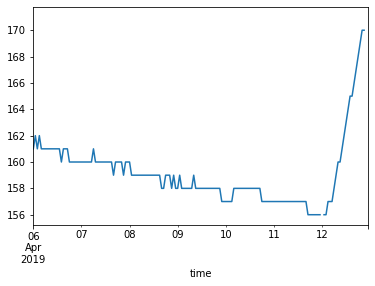

In [31]:
station_main.level_cm.plot()

<AxesSubplot:xlabel='time'>

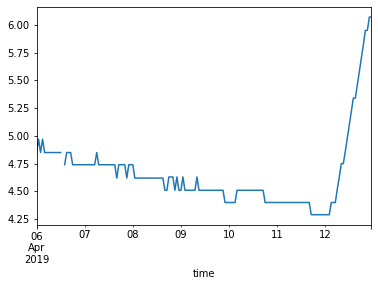

In [32]:
station_main.flow_m3_s.plot()

In [33]:
print(min(station_main.level_cm), min(station_main.flow_m3_s))

156.0 4.29


Logically, both water level and water have to be positive. This is the case here. Otherwise, negative values would be marked as missing value (NaN).

## Station A (Padenstedt) and Station C (Itzehoe)

### rain_mm

This attribute describes precipitation (snow and in Schleswig-Holstein mostly rain). Has to be positive.

count    167.000000
mean       0.068862
std        0.213379
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.100000
Name: rain_mm, dtype: float64


<AxesSubplot:xlabel='time'>

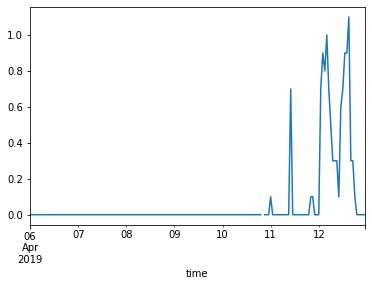

In [34]:
print(station_a.rain_mm.describe())
station_a.rain_mm.plot()

count    167.000000
mean       0.099401
std        0.298086
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.700000
Name: rain_mm, dtype: float64
AxesSubplot(0.125,0.125;0.775x0.755)


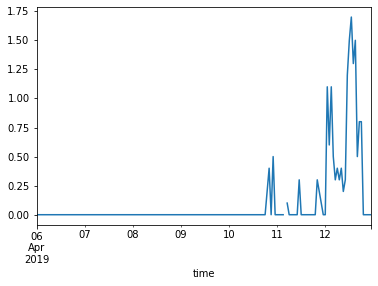

In [35]:
print(station_c.rain_mm.describe())
print(station_c.rain_mm.plot())

Both rain levels have some fixed value -999. These are assumed to be missing values:

In [36]:
station_a.isna().sum()

temp_c     2
status     0
rain_mm    1
dtype: int64

In [37]:
station_a.loc[station_a.rain_mm < 0, "rain_mm"] = np.nan
station_c.loc[station_c.rain_mm < 0, "rain_mm"] = np.nan

### temp_c

This attribute describes the air temperature. A sensible range to check for are based on the min. and max. temperature ever recorded in Germany: [-40°C, 42°C]

(see <https://de.wikipedia.org/wiki/Liste_der_Temperaturrekorde_in_Deutschland#Hitzerekorde>):

count    166.000000
mean       8.556024
std        2.804897
min        2.500000
25%        7.125000
50%        8.100000
75%        9.975000
max       18.300000
Name: temp_c, dtype: float64


<AxesSubplot:xlabel='time'>

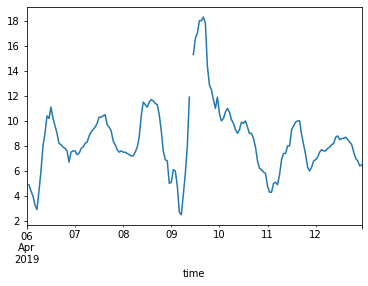

In [38]:
print(station_a.temp_c.describe())
station_a.temp_c.plot()

count    166.000000
mean       8.421084
std        2.762581
min        2.600000
25%        7.025000
50%        8.000000
75%        9.475000
max       18.700000
Name: temp_c, dtype: float64


<AxesSubplot:xlabel='time'>

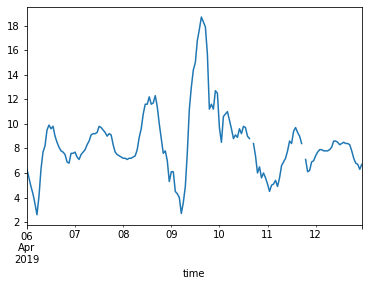

In [39]:
print(station_c.temp_c.describe())
station_c.temp_c.plot()

Station A is fine, but Station C has - like with the precipitation - a articifcal value of -999 which we interpret as missing value:

In [40]:
station_c.loc[station_c.temp_c < -40, "temp_c"] = np.nan

# Missing Values

All attributes show missing values:

In [41]:
print(station_a.isna().sum())
print()
print(station_c.isna().sum())
print()
print(station_main.isna().sum())

temp_c     2
status     0
rain_mm    1
dtype: int64

temp_c     2
status     1
rain_mm    1
dtype: int64

level_cm     2
flow_m3_s    1
dtype: int64


For the categorical attribute status we use forward filling - without any limitation on how many consecutive NaNs can be replaced at a time.

In [42]:
station_a.status.interpolate(method="pad", inplace=True)
station_c.status.interpolate(method="pad", inplace=True)

For the numerical attributes we use linear interpolation

In [43]:
station_a.temp_c.interpolate(method="linear", inplace=True)
station_c.temp_c.interpolate(method="linear", inplace=True)

station_a.rain_mm.interpolate(method="linear", inplace=True)
station_c.rain_mm.interpolate(method="linear", inplace=True)

station_main.level_cm.interpolate(method="linear", inplace=True)
station_main.flow_m3_s.interpolate(method="linear", inplace=True)

# Scaling

## Time Domain

The sampling interval is the same for all station (hourly, starting at 00:00 every day). Scaling in the time domain is not required.

## Value Domain

No scaling (yet).

Scaling due to different value ranges is not necessary (same for rain resp. temp in station A and C) and _level_cm_ is independet from _rain_mm_.

Using normalisation or standardisation for feature scaling depends on the technqiues in following stages. When using Scikit-Learn you can use a transformer called MinMaxScaler for Normalization and one called StandardScaler for standardisation.

# Encoding

Status represents increasing humidity at the station A and station B. Therefore it will rank-based encoded:

In [44]:
# Encode the status
station_a.status = pd.Categorical(station_a.status, categories = ["low", "decreased", "normal", "increased", "max"]).codes
station_c.status = pd.Categorical(station_c.status, categories = ["low", "decreased", "normal", "increased", "max"]).codes

# Final Plots / Stats

## Station Main

         level_cm   flow_m3_s
count  168.000000  168.000000
mean   159.247024    4.657351
std      2.787911    0.329990
min    156.000000    4.290000
25%    157.750000    4.482500
50%    159.000000    4.620000
75%    160.000000    4.740000
max    171.000000    6.070000


<AxesSubplot:xlabel='time'>

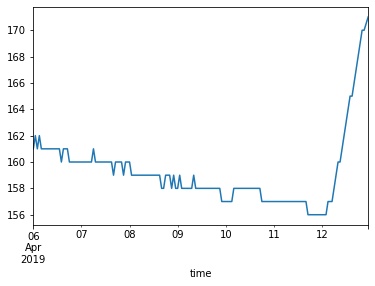

In [45]:
print(station_main.describe())
station_main.level_cm.plot()

<AxesSubplot:xlabel='time'>

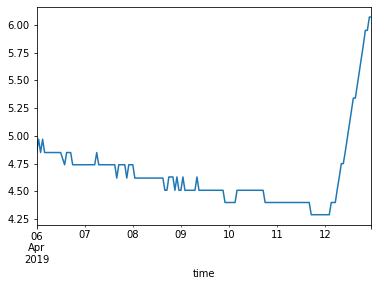

In [46]:
station_main.flow_m3_s.plot()

## Station A and Station C

In [47]:
print(station_a.describe())
print()
print(station_c.describe())

           temp_c      status     rain_mm
count  167.000000  168.000000  168.000000
mean     8.586228    2.303571    0.068452
std      2.823544    0.989520    0.212806
min      2.500000    0.000000    0.000000
25%      7.150000    1.000000    0.000000
50%      8.100000    2.000000    0.000000
75%     10.000000    3.000000    0.000000
max     18.300000    4.000000    1.100000

           temp_c      status     rain_mm
count  168.000000  168.000000  168.000000
mean     8.418155    2.250000    0.099107
std      2.746513    0.946155    0.297216
min      2.600000    1.000000    0.000000
25%      7.075000    1.000000    0.000000
50%      8.000000    2.000000    0.000000
75%      9.425000    3.000000    0.000000
max     18.700000    4.000000    1.700000


<AxesSubplot:xlabel='time'>

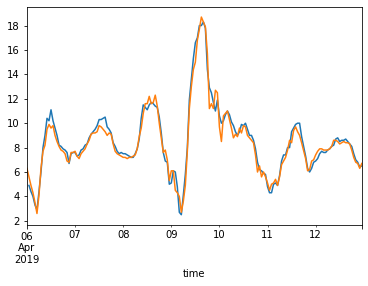

In [48]:
station_a.temp_c.plot()
station_c.temp_c.plot()

<AxesSubplot:xlabel='time'>

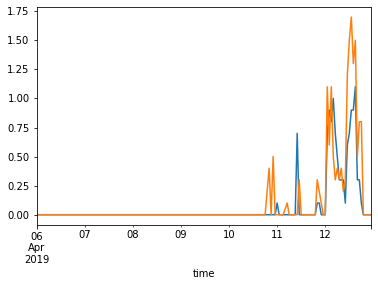

In [49]:
station_a.rain_mm.plot()
station_c.rain_mm.plot()

## Combined Data

Combine the 3 stations using an inner join on index (the datetime) incl. new column names.

In [50]:
all_stations = station_main.join(station_a.join(station_c, how="inner", rsuffix="_from_c"), how="inner")
all_stations.columns = ["main_level", "main_flow", "a_temp", "a_status", "a_rain", "c_temp", "c_status", "c_rain"]
all_stations

,main_level,main_flow,a_temp,a_status,a_rain,c_temp,c_status,c_rain
time,,,,,,,,
2019-04-06 00:00:00,161.0,4.85,NaN,2,0.0,6.3,2,0.0
2019-04-06 01:00:00,162.0,4.97,4.9,2,0.0,5.6,2,0.0
2019-04-06 02:00:00,161.0,4.85,4.4,2,0.0,4.9,2,0.0
2019-04-06 03:00:00,162.0,4.97,4.0,3,0.0,4.3,2,0.0
2019-04-06 04:00:00,161.0,4.85,3.3,3,0.0,3.5,3,0.0
...,...,...,...,...,...,...,...,...
2019-04-12 19:00:00,169.0,5.82,7.5,3,0.0,7.2,3,0.0
2019-04-12 20:00:00,170.0,5.95,7.0,3,0.0,6.8,3,0.0
2019-04-12 21:00:00,170.0,5.95,6.8,3,0.0,6.7,3,0.0


In [51]:
np.sum(pd.isna(all_stations))

main_level    0
main_flow     0
a_temp        1
a_status      0
a_rain        0
c_temp        0
c_status      0
c_rain        0
dtype: int64

# Output

Write the preprocessed files.

In [53]:
# all_stations
all_stations.to_csv(file_all_station)
all_stations
# station_a.to_csv("preprocessed_station_a.csv")
# station_c.to_csv("preprocessed_station_c.csv")
# station_main.to_csv("preprocessed_station_main.csv")
# all_stations.to_csv("preprocessed_stations.csv")

,main_level,main_flow,a_temp,a_status,a_rain,c_temp,c_status,c_rain
time,,,,,,,,
2019-04-06 00:00:00,161.0,4.85,NaN,2,0.0,6.3,2,0.0
2019-04-06 01:00:00,162.0,4.97,4.9,2,0.0,5.6,2,0.0
2019-04-06 02:00:00,161.0,4.85,4.4,2,0.0,4.9,2,0.0
2019-04-06 03:00:00,162.0,4.97,4.0,3,0.0,4.3,2,0.0
2019-04-06 04:00:00,161.0,4.85,3.3,3,0.0,3.5,3,0.0
...,...,...,...,...,...,...,...,...
2019-04-12 19:00:00,169.0,5.82,7.5,3,0.0,7.2,3,0.0
2019-04-12 20:00:00,170.0,5.95,7.0,3,0.0,6.8,3,0.0
2019-04-12 21:00:00,170.0,5.95,6.8,3,0.0,6.7,3,0.0
